<div align="left">
  <h1>EmbedIA</h1>
  <p>EmbedIA is a machine learning framework for developing applications on microcontrollers.</p>
</div>

## Import framework from Github (run only in Colab)

In [1]:
!pip install larq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 2.3 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/Embed-ML/EmbedIA.git

Cloning into 'EmbedIA'...
remote: Enumerating objects: 925, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 925 (delta 58), reused 99 (delta 41), pack-reused 779
Receiving objects: 100% (925/925), 15.40 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (467/467), done.


In [3]:
%cd EmbedIA

/content/EmbedIA


## Load dataset 

In [4]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# 0 to not apply normalization
# 1 for normalization [-0.5, 0.5], 
# 2 for normalization z score, 
_normalize = 2 

def normalization0dot5(x):
    '''
        Normalization of values in the range [-0.5; 0.5]
        Params:
            x: numpy array to be normalized
        Return:
            x: normalized numpy array
    '''
    x = x/np.max(x)
    x = x-0.5
    return x

def z_score(X_train, x_test):
    '''
        Normalization z score, uses mean and standard deviation of train vector
        Params:
            X_train: array of train numpy to be normalized
            x_test: array of test numpy to be normalized
        Return:
            x_train, x_test: normalized numpy vectors
    '''
    x_mean= np.mean(X_train)
    x_std= np.std(X_train)
    
    x_train= (X_train-x_mean)/x_std
    x_test= (x_test-x_mean)/x_std
    return x_train, x_test

def load_dataset(_normalize):
    '''
        Load the sklearn digits dataset, applying the indicated normalization.
        Params:
            _normalize: normalization to be applied
        Return:
           X_train, X_test: training set
           y_train, y_test: test set
    '''

    digits = load_digits()
    
    if _normalize == 1:
        digits.images = normalization0dot5(digits.images)

    X_train, X_test, y_train, y_test = train_test_split(digits.images , digits.target, test_size=0.2, shuffle=True)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

    if _normalize == 2:
        X_train, X_test = z_score(X_train, X_test)

    return X_train, X_test, y_train, y_test

x_train, x_test, y_train, y_test = load_dataset(_normalize)

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

x_train.shape (1437, 8, 8, 1)
x_test.shape (360, 8, 8, 1)


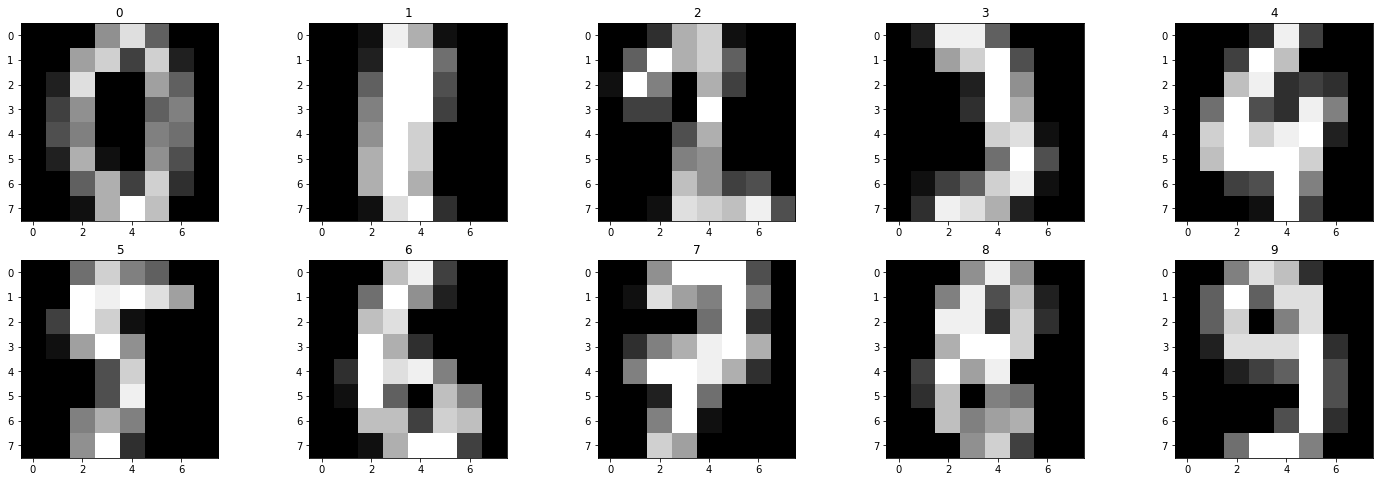

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=((5*25)//5, (2*8)//2))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(x_train[np.where(y_train==i)[0][0]], cmap="gray")
    axes[i].set_title(str(i))

plt.show()

## Creating and training a CNN model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, BatchNormalization

def create_model(x_train, y_train, y_test):
    '''
        Create a model
        Input parameters:
            x_train: training data
            y_train, y_test: labels of the data involved (including test data)

        return
            model: sequential layers model
    '''
    classes = max(y_test.max(),y_train.max())+1

    model = Sequential(name="EmbedIA_model")

    model.add(Conv2D(8, kernel_size=(3, 3), input_shape=x_train[0].shape,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(2, 2),activation='relu'))

    model.add(Flatten())
    model.add(Dense(16,activation='relu'))
    model.add(Dense(classes,activation='softmax'))

    model.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['acc'])
    return model

model = create_model(x_train, y_train, y_test)
model.summary()

Model: "EmbedIA_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 8)           80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 16)          528       
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                     

### Training

In [6]:
epocas = 50
lote = 32

history = model.fit(x_train, y_train, epochs=epocas, batch_size=lote, validation_data=(x_test, y_test))

Epoch 1/50
45/45 [==============================] - 5s 18ms/step - loss: 2.2097 - acc: 0.1935 - val_loss: 2.1009 - val_acc: 0.2111
Epoch 2/50
45/45 [==============================] - 0s 9ms/step - loss: 1.8623 - acc: 0.4210 - val_loss: 1.6332 - val_acc: 0.4722
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 1.2813 - acc: 0.6486 - val_loss: 1.0144 - val_acc: 0.7861
Epoch 4/50
45/45 [==============================] - 0s 9ms/step - loss: 0.8219 - acc: 0.8051 - val_loss: 0.6809 - val_acc: 0.8333
Epoch 5/50
45/45 [==============================] - 0s 10ms/step - loss: 0.6044 - acc: 0.8392 - val_loss: 0.5254 - val_acc: 0.8722
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 0.4859 - acc: 0.8747 - val_loss: 0.4409 - val_acc: 0.8750
Epoch 7/50
45/45 [==============================] - 0s 9ms/step - loss: 0.4287 - acc: 0.8768 - val_loss: 0.3797 - val_acc: 0.9028
Epoch 8/50
45/45 [==============================] - 0s 6ms/step - loss: 0.3679 - acc: 0.

### Plot history

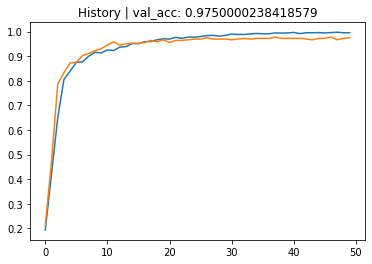

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("History | val_acc: "+str(history.history['val_acc'][len(history.history['val_acc'])-1]))
plt.show()

### Save the model

In [8]:
model_name = "mnist_model.h5"
model.save("models/" + model_name)

## Convert model for inference in the microcontroller using EmbedIA

In [15]:
#@title Configuration and execution of the exporter { display-mode: "form" }

import sys
# add parent folder to path in order to find EmbedIA folder
sys.path.insert(0, '..')

import joblib
from tensorflow.keras.models import load_model
from embedia.project_generator import ProjectGenerator
from embedia.model_generator.project_options import (
    ModelDataType,
    DebugMode,
    ProjectFiles,
    ProjectOptions,
    ProjectType
)

#@markdown ---
#@markdown ###Export adjustment

OUTPUT_FOLDER = 'outputs/' #@param {type:"string"}
PROJECT_NAME = 'mnist_project' #@param {type:"string"}

MODEL_FILE = 'models/mnist_model.h5' #@param {type:"string"}
model = load_model(MODEL_FILE)
# model.summary()

options = ProjectOptions()

# set location of EmbedIA folder
embedia_folder = '../EmbedIA/embedia'
options.embedia_folder = embedia_folder

#@markdown ---
#@markdown ###Configuration of the project to export

# set project type
project_type_dict = {
    "ARDUINO": ProjectType.ARDUINO, 
    "C": ProjectType.C,
    "CODEBLOCK": ProjectType.CODEBLOCK,
    "CPP": ProjectType.CPP,
}
project_type = "CODEBLOCK" #@param ["ARDUINO", "C", "CODEBLOCK", "CPP"]
options.project_type = project_type_dict[project_type]

# set data type
data_type_dict = {
    "FLOAT": ModelDataType.FLOAT, 
    "FIXED32": ModelDataType.FIXED32,
    "FIXED16": ModelDataType.FIXED16,
    "FIXED8": ModelDataType.FIXED8,
    "BINARY": ModelDataType.BINARY,
}
data_type = "FIXED16" #@param ["FLOAT", "FIXED32", "FIXED16", "FIXED8", "BINARY"]
options.data_type = data_type_dict[data_type]

# set debug mode
debug_mode_dict = {
    "DISCARD": DebugMode.DISCARD, 
    "DISABLED": DebugMode.DISABLED,
    "HEADERS": DebugMode.HEADERS,
    "DATA": DebugMode.DATA,
}
debug_mode = "DATA" #@param ["DISCARD", "DISABLED", "HEADERS", "DATA"]
options.debug_mode = debug_mode_dict[debug_mode]

# set which files to export
files_export_dict = {
    "ALL": ProjectFiles.ALL, 
    "MAIN": {ProjectFiles.MAIN},
    "MODEL": {ProjectFiles.MODEL},
    "LIBRARY": {ProjectFiles.LIBRARY},
}
files_export = "ALL" #@param ["ALL", "MAIN", "MODEL", "LIBRARY"]
options.files = files_export_dict[files_export]

# examples to export
samples = x_test[0:10]
ids = y_test[0:10]

res = model.predict(samples)
print((res*100).astype('int'))

options.example_data = samples
options.example_ids = ids

#@markdown if True, remove output folder and start a clean export:
clean_output = True #@param {type:"boolean"}
options.clean_output = clean_output
#@markdown ---

############# Generate project #############

generator = ProjectGenerator(options)
generator.create_project(OUTPUT_FOLDER, PROJECT_NAME, model, options)

print("Project", PROJECT_NAME, "exported in", OUTPUT_FOLDER,'\n\n')

import larq
larq.models.summary(model)

1/1 [==============================] - 0s 118ms/step
[[ 0  0  0  0  0  0  0  0 99  0]
 [ 0  0  0 99  0  0  0  0  0  0]
 [ 0  0  0  0 99  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0 98  0]
 [ 0  0  0  0  0 99  0  0  0  0]
 [ 0  0  0  0  0  0 99  0  0  0]
 [ 0  0 99  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 99]
 [ 0  0  0  0  0  0  0  0 99  0]
 [ 0  0  0 99  0  0  0  0  0  0]]

+-------------------+---------------+------------+------------+------+------------+
| Layer(activation) | Name          | #Param(NT) |   Shape    | MACs | Size (KiB) |
+-------------------+---------------+------------+------------+------+------------+
| Conv2D(relu)      | conv2d        |         80 | (6, 6, 8)  | 2592 |     0.141  |
| MaxPooling2D      | max_pooling2d |          0 | (3, 3, 8)  |    0 |     0.000  |
| Conv2D(relu)      | conv2d_1      |        528 | (2, 2, 16) | 2048 |     0.641  |
| Flatten           | flatten       |          0 |   (64,)    |    0 |     0.000  |
| Dense(relu)       | dense

### Download generated project (Run only in Colab)

In [16]:
from google.colab import files

!zip -r embedia_project.zip 'outputs/mnist_project'
files.download('/content/EmbedIA/embedia_project.zip')

updating: outputs/mnist_project/ (stored 0%)
updating: outputs/mnist_project/mnist_project.cbp (deflated 74%)
updating: outputs/mnist_project/embedia.c (deflated 79%)
updating: outputs/mnist_project/example_file.h (deflated 93%)
updating: outputs/mnist_project/fixed.c (deflated 73%)
updating: outputs/mnist_project/fixed.h (deflated 74%)
updating: outputs/mnist_project/embedia_debug.h (deflated 55%)
updating: outputs/mnist_project/embedia_model.c (deflated 67%)
updating: outputs/mnist_project/embedia_debug_def.h (deflated 69%)
updating: outputs/mnist_project/embedia_debug.c (deflated 76%)
updating: outputs/mnist_project/main.c (deflated 49%)
updating: outputs/mnist_project/embedia.h (deflated 74%)
updating: outputs/mnist_project/embedia_model.h (deflated 60%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>